# Peak calling testing: try peakcalling of Read1 only

05/18/23

In [1]:
from subprocess import Popen, PIPE, DEVNULL
from tempfile import TemporaryDirectory
from itertools import product
from pathlib import Path
from io import StringIO
from scripts.get_labels import read_knrgl, read_rmsk, label_windows
import pandas as pd
import pyranges as pr
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# define inputs
bam = "/iblm/netapp/data4/mcuoco/sz_slavseq/results/align/8/gDNA_usd8.tagged.sorted.bam"
knrgl = read_knrgl("/iblm/netapp/data4/mcuoco/sz_slavseq/resources/8_insertions.bed")
rmsk = read_rmsk("/iblm/netapp/data4/mcuoco/sz_slavseq/resources/hs38d1.fa.out")

# create play directory
Path("peak_calling").mkdir(exist_ok=True)

# write as bed files
pr.PyRanges(knrgl).to_bed("peak_calling/8_insertions.bed")

# remove rmsk records with negative start or end
rmsk = rmsk[(rmsk.Start >= 0) & (rmsk.End >= 0)].drop(["repeat"], axis=1)
pr.PyRanges(rmsk).to_bed("peak_calling/hs38d1_rmsk.bed")

# define test inputs
# bam = "/iblm/logglun02/mcuoco/workflows/sz_slavseq/.test/results/align/1/A.tagged.sorted.bam"

In [3]:
# define helper functions
def bedtools_intersect(bam, bed):
    cmd = f"bedtools intersect -abam {bam} -b {bed} -bed -wa -wb -S"
    p = Popen(cmd, shell=True, stdout=PIPE, stderr=DEVNULL)
    names = [
        "Chromosome",
        "Start",
        "End",
        "read_id",
        "mapq",
        "Strand",
        "intersect_start",
        "intersect_end",
        "x",
        "y",
        "flag",
        "z",
        "ChromosomeB",
        "StartB",
        "EndB",
        "NameB",
        "ScoreB",
        "StrandB",
    ]

    with StringIO(p.stdout.read().decode()) as bed:
        df = pd.read_csv(bed, sep="\t", header=None, names=names)
        df.drop(["x", "y", "z"], axis=1, inplace=True)

    return df


def overlap(a, b):
    a = pr.PyRanges(a)
    b = pr.PyRanges(b)
    return b.overlap(a).df


def intersect(a, b):
    a = pr.PyRanges(a)
    b = pr.PyRanges(b)
    return b.intersect(a).df

### How many known insertions are covered? By how many reads?

In [4]:
knrgl_reads = bedtools_intersect(bam, "peak_calling/8_insertions.bed")
knrgl_reads["label"] = "KNRGL"
rmsk_reads = bedtools_intersect(bam, "peak_calling/hs38d1_rmsk.bed")
rmsk_reads["label"] = "RMSK"
df = (
    pd.concat([knrgl_reads, rmsk_reads])
    .groupby(["ChromosomeB", "StartB", "EndB", "label"])
    .size()
    .reset_index(name="reads")
)

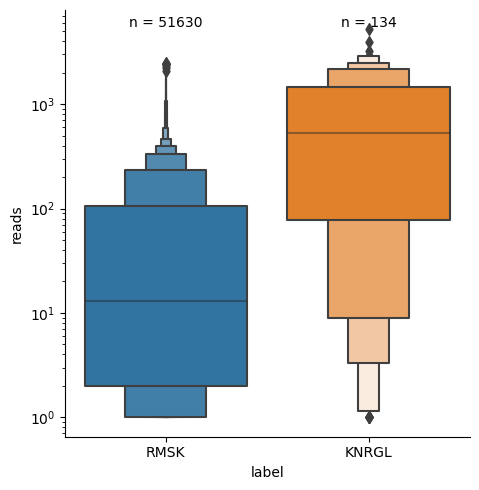

In [5]:
g = sns.catplot(x="label", y="reads", data=df, kind="boxen")

# add number on top of each violin
for tick, label in enumerate(g.ax.get_xticklabels()):
    n = len(df[df["label"] == label.get_text()])
    g.ax.text(
        tick, max(df["reads"]) + 300, "n = " + str(n), horizontalalignment="center"
    )

# log scale y axis
g.ax.set_yscale("log")

### Call peaks with MACS2

In [8]:
def macs2(
    bam: str,
    bandwidth: int = 200,
    extsize: int = 200,
    slocal: int = 1000,
    llocal: int = 10000,
):

    header = [
        "Chromosome",
        "Start",
        "End",
        "Name",
        "Score",
        "Strand",
        "FoldChange",
        "-log10pvalue",
        "-log10qvalue",
        "summit",
    ]
    with TemporaryDirectory() as tmpdir:
        macs2_cmd = f"macs2 callpeak -t {bam} -f BAM -g hs --nomodel --extsize {extsize} --bw {bandwidth} --outdir {tmpdir} --name macs2 --slocal {slocal} --llocal {llocal}"

        # narrow peaks
        Popen(macs2_cmd, shell=True, stdout=DEVNULL, stderr=DEVNULL).communicate()
        narrowpeaks = pd.read_csv(
            f"{tmpdir}/macs2_peaks.narrowPeak", sep="\t", header=None, names=header
        )

        # broad peaks
        Popen(
            macs2_cmd + " --broad", shell=True, stdout=DEVNULL, stderr=DEVNULL
        ).communicate()
        broadpeaks = pd.read_csv(
            f"{tmpdir}/macs2_peaks.broadPeak", sep="\t", header=None, names=header[:-1]
        )

    return narrowpeaks, broadpeaks


def metrics(peaks: pd.DataFrame, knrgl: pd.DataFrame, rmsk: pd.DataFrame):

    peaks["width"] = peaks["End"] - peaks["Start"]
    peaks = label_windows(peaks, knrgl, "knrgl")
    peaks = label_windows(peaks, rmsk, "rmsk")

    label = []
    for row in peaks.itertuples():
        if row.rmsk:
            label.append("RMSK")
        elif row.knrgl:
            label.append("KNRGL")
        else:
            label.append("OTHER")

    peaks.drop(["knrgl", "rmsk"], axis=1, inplace=True)
    peaks["label"] = label

    return peaks

In [9]:
params = {
    "bandwidth": [200, 500],
    "extsize": [200, 500],
    "local": [
        (1000, 10000),
        (2000, 10000),
        (3000, 10000),
        (4000, 10000),
        (5000, 10000),
    ],
}

res = []
for bandwidth, extsize, local in product(*params.values()):
    slocal, llocal = local
    narrowpeaks, broadpeaks = macs2(
        bam, bandwidth=bandwidth, extsize=extsize, slocal=slocal, llocal=llocal
    )

    narrowpeaks = metrics(narrowpeaks, knrgl, rmsk)
    narrowpeaks["type"] = "narrow"
    narrowpeaks["bandwidth"] = bandwidth
    narrowpeaks["extsize"] = extsize
    narrowpeaks["slocal"] = slocal
    narrowpeaks["llocal"] = llocal
    res.append(narrowpeaks)

    broadpeaks = metrics(broadpeaks, knrgl, rmsk)
    broadpeaks["type"] = "broad"
    broadpeaks["bandwidth"] = bandwidth
    broadpeaks["extsize"] = extsize
    broadpeaks["slocal"] = slocal
    broadpeaks["llocal"] = llocal

    res.append(broadpeaks)

res = pd.concat(res)

In [ ]:
res